# Leapfrog

0.2 759.9088773175331 0.006079271018540265


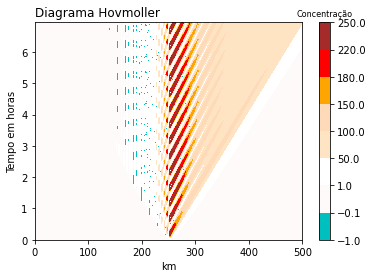

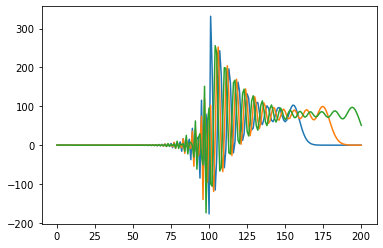

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from matplotlib import animation, rc
from functions import *
import scipy.sparse as sp

# Condições do exercício
# ----------------------
Nx, dx, Nt, dt, U  = 201, 2500, 501, 50, 10, 
x, _ = np.linspace(0, (Nx-1)*dx, Nx, retstep = True)
t, _ = np.linspace(0, (Nt-1)*dt, Nt, retstep = True)
CFL     = U*dt/dx
ylabel =  ["Concentração","Emissão" ]
C = np.zeros((Nx, Nt))
F = C.copy()
w = int(dx/(dt*U)) # w*dt*U/dx = 1; w*dt = dx
T, X = np.meshgrid(t, x)
om = 2*np.pi/1800
te = 3*3600 # seconds decaimento
K = 1/(te*(om/U)**2) # kappa
v = K*dt/(dx)**2  # nu
print(CFL, K, v)
levels=[-1,-.1, 1, 50, 100, 150, 180, 220, 250]
# ----------------------

for n in range(1, Nt-1):
    # Euler forward
    if n == 1:
        # Inicialmente F no tempo n, Euler forward-backward
        F[101, n] = 1/2*(wave(t, n) + wave(t, n-1))
        for j in range(1, Nx-1): 
            C[j,n+1] = C[j,n] - CFL*(C[j,n]-C[j-1,n]) + v*(C[j+1,n]-2*C[j,n]+C[j-1,n]) + dt*(F[j,n])
    else: # Fonte e difusão como n-1
        F[101, n-1] = 1/2*(wave(t, n-1) + wave(t, n-2))
        for j in range(1, Nx-1):
            C[j,n+1] = C[j,n-1] - CFL*(C[j+1,n]-C[j-1,n]) + 2*v*(C[j+1,n-1]-2*C[j,n-1]+C[j-1,n-1]) + 2*dt*(F[j,n-1])
    
    # Radiacional
    C[-1, n+1] = C[-1, n] - CFL*(C[-1, n]- C[-2, n]) 

Cl = C.copy()
hovm(X, T, Cl, F, ylabel, "leapfrog", n, dt, t, alfa=0, gamma=0, fonte=False, levels=levels)
fig, ax = plt.subplots(1)
for n in [ 300, 400, 500]:
    ax.plot(Cl[:,n])

# Leapfrog 2a ordem com operador splitting

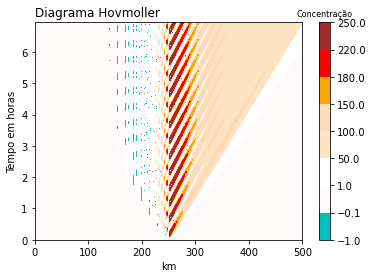

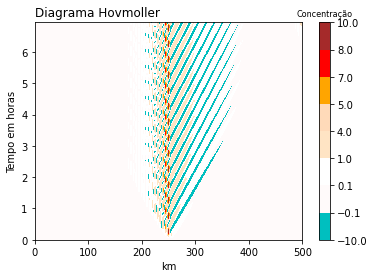

In [40]:
C = np.zeros((Nx, Nt))
Cs = C.copy()
F = C.copy()
gamma = 0.05 #0.1, 0.01
alfa = 0.53 #0.53
f_space, f_time =  True, True
levels2=[-10,-.1,.1,1, 4,5, 7, 8, 10]

for n in range(1, Nt-1):
    # Euler forward
    if n == 1:
        # Inicialmente F no tempo n, Euler forward-backward
        F[101, n] = 1/2*(wave(t, n) + wave(t, n-1))
        for j in range(1, Nx-1):
            # Passo 1
            Cs[j,n+1] = C[j,n] - CFL*(C[j,n]-C[j-1,n]) + v*(Cs[j+1,n]-2*Cs[j,n]+Cs[j-1,n])
            # Passo 2
            C[j,n+1] = Cs[j,n+1] + dt*(F[j,n])
            
    else: # Fonte e difusão como n-1
        F[101, n-1] = 1/2*(wave(t, n-1) + wave(t, n-2))
        for j in range(1, Nx-1):
            # Passo 1
            Cs[j,n+1] = C[j,n-1] - CFL*(C[j+1,n]-C[j-1,n]) + 2*v*(Cs[j+1,n-1]-2*Cs[j,n-1]+Cs[j-1,n-1])
            # Passo 2
            C[j,n+1] = Cs[j,n+1] + 2*dt*F[j,n-1]
    
    # Radiacional
    C[-1, n+1] = C[-1, n] - CFL*(C[-1, n]- C[-2, n])

Csp = C.copy()

hovm(X, T, Csp, F, ylabel, "leapfrog_splitting", n, dt, t, alfa=0, gamma=0, fonte=False, levels=levels)
hovm(X, T, Cl-Csp, F, ylabel, "leapfrog_dif", n, dt, t, alfa=0, gamma=0, fonte=False, levels=levels2)

In [38]:
filenames = []
# plot the line chart
for n in range(0,Nt,2):
    fig, ax = plt.subplots(figsize=[12,4])
    ax.plot(x/1000, Cl[:,n], color = 'g', linestyle = 'solid', label="Leapfrog 2")
    ax.plot(x/1000, Csp[:,n], color = 'crimson', linestyle = 'solid', label="Leapfrog splitting")
    ax.set_ylim(-50,400)
    ax.set_title(f"N° passo tempo={n}.")
    ax.legend()
    ax.set_ylabel(ylabel[0])

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=300)
    plt.close() # build gif

with imageio.get_writer('gifs/leap_split.gif', mode='I', duration = .2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove files
for filename in set(filenames):
    os.remove(filename)  